In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.dpi'] = 100

# Decay of a spin with the Lindblad master equation

Here, we will use QuTiP to solve the problem discussed in class of the decay of a spin due to the emission of a photon. 

## Setting up the problem

We will first create initial state in the 2-dimensional Hilbert space. 

Note that `basis(N,0)` is completely identical to the function `fock(N,0)` we used earlier. We use this one here just because it is (maybe) strange to call the levels of a spin "Fock" states.

In the last line, we will print out the state we created to make sure it is what we think it is.

In [4]:
N = 2
psi0 = basis(N,0)
psi0 = psi0.unit()
psi0

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

Now, we need an operator with the following matrix for our "collapse" opeartor, which is the 

$$
\hat \sigma_{-} = 
\begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}
$$

This is identical to the "creation" operator, as it turns out, for the harmonic oscillator (HO). (This is because spin-up has higher energy but it is the first row of the basis state, whereas the first row for the HO is the ground state.). 

But, again, it would be confusing to write code for a spin that uses HO operators. Fortunately, QuTiP has a built-in functions to generate the Pauli matrices:

http://qutip.org/docs/latest/apidoc/functions.html#qutip.operators.sigmam

We will use `sigmam()` to make the annihilation operator:

In [5]:
sig_m = sigmam()
sig_m

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

And, we can double-check that it does what we think it should: 

$$
\hat \sigma_- \left| \uparrow \right\rangle = \left| \downarrow \right\rangle
$$

In [6]:
sig_m*psi0

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

Good, this is indeed what we expect! 

Now, we need the Hamiltonian. For the Hamiltonian, we will pick just the $\sigma_z$ operator:

$$
\hat H = \tfrac{1}{2} \hat \sigma_z
$$

In [7]:
H = 0.5 * sigmaz()
H

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]

This implicitly means that we are choosing a Larmor frequency:

$$
\omega_L = \frac{1}{\hbar} = 2\pi \times \frac{1}{h} = 2\pi \times 1.5 \times 10^{33}\  {\rm Hz}
$$

The may seem mega-fast ($10^{33}$ Hz), and it is! It turns out, however, that when QuTiP solves time-dependent Hamiltonians, it rescales the time-variables in the problem such that $\hbar = 1$. Our  choice of $\hat H  = \frac{1}{2}\hat \sigma_z$ leads to an angular Larmor frequency of:

$$
\omega_L = 1\ {\rm rad / sec} = 0.15\ {\rm Hz}
$$

in "QuTiP" variables. This is not a big deal: it just changes the rescaling of the time axis of any plots. But one should be careful to remember what the time axis means when performing a simulation. 

Even more convenient for plotting, though, is to choose $\omega_L = 2\pi$ so that the oscillations we will see, for example in $S_x$ for a superposition state will have a period of 1 second (1 time unit):

In [8]:
w = 1 * 2 * np.pi 
H = 0.5 * w * sigmaz()

## Solving the master equation

We now have everything we need to solve the (Lindblad) master equation!

http://qutip.org/docs/latest/guide/dynamics/dynamics-master.html

To do this, we need to use the qutip function `mesolve()`: 

http://qutip.org/docs/latest/apidoc/functions.html#module-qutip.mesolve

For QuTiP to solve the master equation, we need to give it a few thigns:

* `H`: the Hamiltonian
* `psi0`: the quantum state at $t=0$ (density matrix or wave function)
* `t`: A list of times for which you would like the solution
* `c_ops`: A python "list" of collapse operators

For our collapse operator, we will need to scale the $\sigma_-$ operator by $\sqrt{\gamma}$, where $\gamma$ is the average rate that the collapse is applied (the average number of collapses that occur per second):

$$
\hat C = \sqrt{\gamma}\ \hat \sigma_-
$$

Like $\omega_L$, the rate $\gamma$ has the units equivalent to 1 / second. If we choose $\gamma = 2\pi \times 0.1 $, then with our choice of $\hat H = \frac{1}{2} \hat \sigma_z$, how many oscillations will we see in $\sigma_x$ for exmaple if we started with $|x+\rangle$? For a function $f(x) = e^{-\gamma t/2} \cos(\omega_t)$, we would then observe $10/(2\pi) = 1.59$ oscillations by the time the amplitude decays by $1/e$. 

Since we are performing only one measurement, we all we have to do is put this operator in square brackets to create our `c_ops` python list:

In [9]:
gamma = 0.1 * w
c_ops = [np.sqrt(gamma) * sig_m]

Now, we need to create the time array at which we want QuTiP to give us the solution of the master equation:

In [10]:
t = np.linspace(0, 10, 401) 

And then we can just call `mesolve()`:

In [11]:
result = mesolve(H, psi0, t, c_ops)

Finally, we will use the projection operator to extract values of the density matrix to plot:

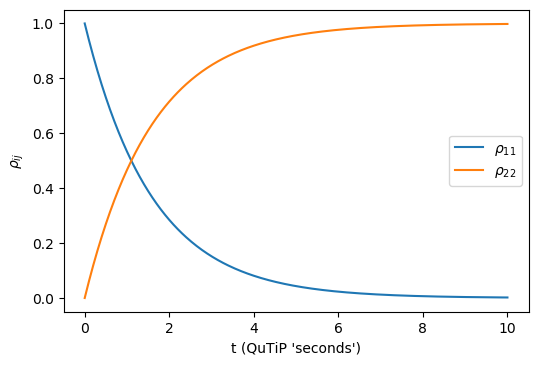

In [13]:
plt.plot(t,np.real(expect(result.states, projection(2,0,0))), label=r'$\rho_{11}$');
plt.plot(t,expect(result.states, projection(2,1,1)), label=r'$\rho_{22}$');
plt.ylabel(r"$\rho_{ij}$")
plt.xlabel("t (QuTiP 'seconds')")
plt.legend()
plt.show()

In [ ]:
result = mesolve(H, psi0, t, c_ops)